# Autoencoder Variacional (VAE) com Keras

Este notebook implementa um VAE utilizando o dataset MNIST, com comentários explicativos em português.

In [ ]:
# Importando as bibliotecas necessárias
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
import tensorflow as tf

In [ ]:
# Carregando e preparando os dados do MNIST com tf.data.Dataset para melhor desempenho
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = np.reshape(x_test, (-1, 28, 28, 1))

# Criando datasets otimizados para treinamento com GPU
train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(128).prefetch(tf.data.AUTOTUNE)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Definindo o tamanho da entrada e do espaço latente
input_shape = (28, 28, 1)
latent_dim = 2  # para visualização

In [ ]:
# Camada de amostragem (reparametrização)
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
# Construindo o codificador
encoder_inputs = keras.Input(shape=input_shape)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

In [ ]:
# Construindo o decodificador
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")

In [ ]:
# Definindo o modelo VAE com tf.function para aceleração em GPU
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def compile(self, optimizer):
        super(VAE, self).compile()
        self.optimizer = optimizer
        self.total_loss_tracker = keras.metrics.Mean(name="loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    @tf.function
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
# Compilando e treinando o VAE com dataset otimizado para GPU
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(train_dataset, epochs=30)

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - kl_loss: 1.3363 - loss: 260.8916 - reconstruction_loss: 259.5553
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 4.5718 - loss: 168.9178 - reconstruction_loss: 164.3459
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 4.9616 - loss: 163.6005 - reconstruction_loss: 158.6389
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 5.2188 - loss: 160.8109 - reconstruction_loss: 155.5920
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 5.3494 - loss: 159.1906 - reconstruction_loss: 153.8411
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 5.4387 - loss: 157.9417 - reconstruction_loss: 152.5030
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - kl_loss: 5.5218 - loss: 157.0199 - reconstruction_loss: 151.4980
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 5.6132 - loss: 156.2368 - reconstruction_loss: 150.6236
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


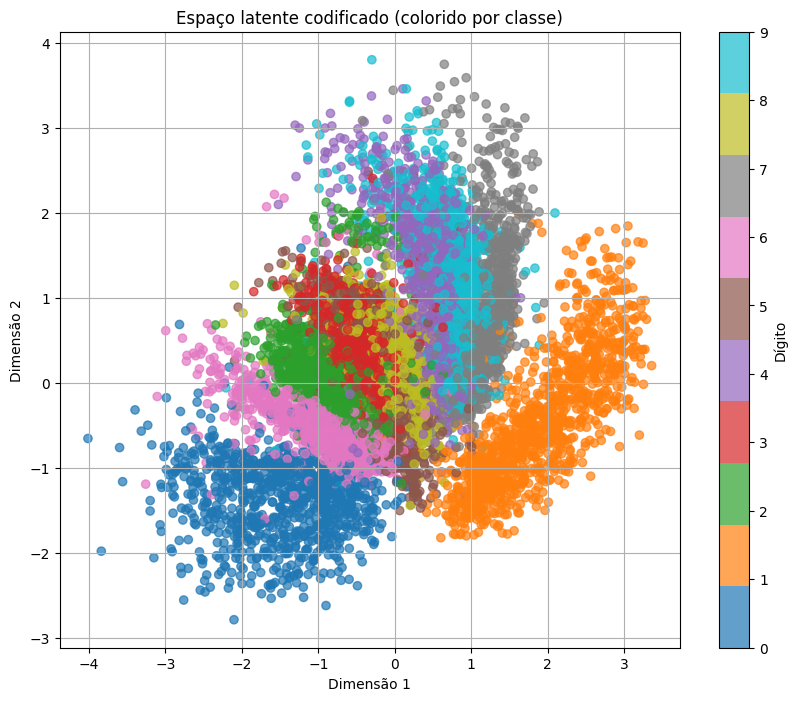

In [ ]:
# Visualizando o espaço latente com os dados de teste
z_mean, _, _ = encoder.predict(x_test)
plt.figure(figsize=(8, 6))
plt.scatter(z_mean[:, 0], z_mean[:, 1], alpha=0.5)
plt.title("Representação no espaço latente")
plt.xlabel("Dimensão 1")
plt.ylabel("Dimensão 2")
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step


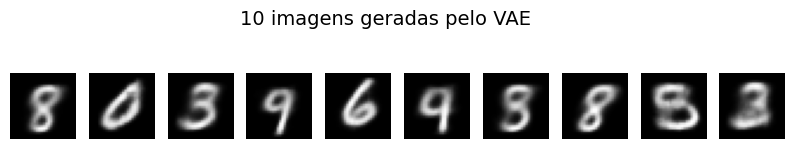

In [ ]:
# Gerando novas amostras a partir do espaço latente
def gerar_amostras(decoder, n=10):
    # Amostrando pontos do espaço latente (normal padrão)
    z_samples = np.random.normal(size=(n, latent_dim))

    # Gerando imagens com o decodificador
    generated_images = decoder.predict(z_samples)

    # Plotando as imagens geradas
    plt.figure(figsize=(n, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(generated_images[i].squeeze(), cmap="gray")
        plt.axis("off")
    plt.suptitle(f"{n} imagens geradas pelo VAE", fontsize=14)
    plt.show()

# Gerar e exibir 10 amostras
gerar_amostras(decoder, n=10)